# Exercise Sheet 5 - Segmentation & Denoising with U-Net

 * Deep Learning for Computer Vision - Winter Term 2022/23
 * Organizers: Anwai Archit, Laura Hansel, Michaela Vystrcilova, Constantin Pape
 * Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
 * Due date: **Mon, Jan 16, before 14:00**

In this assignment we will use a U-Net for two different tasks:
- semantic and instance segmentation of nuclei in microscopy images
- denoising of natural images

## Hints

The goal of the first part of the exercise (segmentation) is to implement the U-Net architecture very similar to the original publication and then use it for its initial purpose, semantic segmentation. In the second part we will use the same U-Net implementation, but use it for a different task: denoising, following the ideas of noise-to-noise. 

To understand the background of this exercise you can:

* Review the lecture (Lecture 7 for U-Net architecture, Lecture 8 for noise-to-noise)
* Read the [U-net publication](https://arxiv.org/abs/1505.04597).
* Read the [noise-to-noise publication](https://arxiv.org/abs/1803.04189).

Note that we will implement the same ideas as in these papers, but will deviate from the implementation details and conduct different and fewer experiments.
 
*Do not hesitate to ask questions and ideally discuss them with the fellow students on Rocket Chat! We will monitor the channel to provide you help if your discussions get stuck.*

### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>\_\<surname2\>\_\<surname3\>.ipynb
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission for Homework 5`.
- Make only one submission of the exercise per group.
- The deadline is strict
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Only change code to replace placeholders. Leave the other code as is. In addition to the python packages loaded below you are allowed to use any packages you want.


**Import required libraries.**

In [1]:
import os
import zipfile
from glob import glob
from pathlib import Path

# for egi, remove 2 rows below if needed
!pip install imageio
import imageio as imageio
# import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import requests
import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader

from matplotlib import colors
import scipy
from scipy.optimize import linear_sum_assignment
from skimage.measure import label
from skimage.metrics import contingency_table, peak_signal_noise_ratio
from skimage.segmentation import find_boundaries, watershed
import skimage
from skimage.util import random_noise
extract_metrics = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# create a root folder where to save the data for this exercise in Kaggle
root_folder = "/kaggle/working/dlforcv-ex5"
os.makedirs(root_folder, exist_ok=True)

## Segmentation

In the first part of the exercise we will implement the U-Net architecture and apply it to a segmentation problem in microscopy: segmenting nuclei in fluorescence images. The data we are using is a subset of the [Kaggle Nucleus Segmentation challenge](https://www.kaggle.com/c/data-science-bowl-2018).

### Data preparation

In [3]:
# download the data
data_folder = os.path.join(root_folder, "kaggle-data")
url = "https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip"
if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    tmp_path = os.path.join(data_folder, "data.zip")
    with requests.get(url) as r:
        with open(tmp_path, "wb") as f:
            f.write(r.content)
    with zipfile.ZipFile(tmp_path, "r") as f:
        f.extractall(data_folder)
    os.remove(tmp_path)
data_folder = os.path.join(data_folder, "dsb2018")
assert os.path.exists(data_folder)

**Data exploration**

The data is stored in the root folder `dsb2018` and contains the two subfolders `train` and `test` with train/test split. Each of these folders contains the folders `images` with the raw image data and `masks` with the instance masks. As a first step, we will visualize some of the images and labels from the training data.

In [4]:
image_paths = glob(os.path.join(data_folder, "train", "images", "*.tif"))
image_paths.sort()
mask_paths = glob(os.path.join(data_folder, "train", "masks", "*.tif"))
mask_paths.sort()
assert len(image_paths) == len(mask_paths)

In [5]:
# a function to generate a random color map for a label image
def get_random_colors(labels):
    n_labels = len(np.unique(labels)) - 1
    cmap = [[0, 0, 0]] + np.random.rand(n_labels, 3).tolist()
    cmap = colors.ListedColormap(cmap)
    return cmap

In [6]:
def plot_sample(image_path, mask_path):
    image, mask = imageio.imread(image_path), imageio.imread(mask_path)
    fig, ax = plt.subplots(1, 2)
    ax[0].axis("off")
    ax[0].imshow(image, cmap="gray")
    # visualize the masks with random colors
    ax[1].axis("off")
    ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
    plt.show()

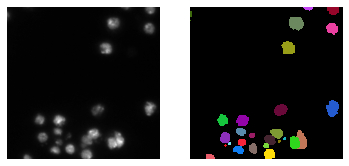

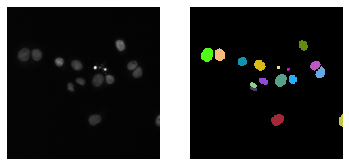

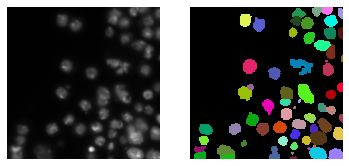

In [7]:
# plot the first 4 images
for i in range(4):
    plot_sample(image_paths[i], mask_paths[i])

You should see 4 images with nuclei and the corresponding colored nuclei masks. To further understand and explain the data, please answer the following QUESTIONS:
- Do the ids assigned to the individual nuclei (= colors in the 2nd column of images) have a fixed meaning? In other words, would the segmentation change if we change shuffle these numbers, so that all pixels labeled `1` are labeled `2` and so on?
 - No they don't really matter, they are just there to separate the different classes
- Can we directly use a U-Net to predict the mask ids? Why / Why not?
 - No, because we can't expect and want the model to learn the id's, just the segmentation.
- Find the unique shapes of the images in the training set.
 - Ok!
- Do all images have the same shape? If not, can this lead to problems? How could we deal with potentially arising problems?
 - They don't have the same shapes. We could potentially only take crops from the larger images

In [8]:
# TODO find how many images we have in the training set
# and find all (unique) shapes of the images in the training set
print("how many images: ", len(image_paths))
unique_sizes = []
for i in range(len(image_paths)):
  im = imageio.imread(image_paths[i])
  if not im.shape in unique_sizes:
    unique_sizes.append(im.shape)
print("unique shapes of images: ", len(unique_sizes))
print(unique_sizes)

how many images:  447
unique shapes of images:  6
[(256, 256), (360, 360), (260, 347), (520, 696), (512, 640), (256, 320)]


TODO your answer here

In [9]:
# TODO now load the images and masks into memory, and normalize the images so that they have zero mean and unit variance
images = list()
for i in image_paths:
    images.append(imageio.imread(i))
masks = list()
for i in mask_paths:
    masks.append(imageio.imread(i))

In [10]:
ims_flat = np.concatenate([im.ravel() for im in images])
mean, std = np.mean(ims_flat), np.std(ims_flat)
images = [(im.astype("float32") - mean) / std for im in images]

In [11]:
# TODO make a train validation split, use every 20th image for validation
train_images = [images[i] for i in range(len(images)) if i % 20 != 0]
train_masks = [masks[i] for i in range(len(masks)) if i % 20 != 0]
val_images = [images[i] for i in range(len(images)) if i % 20 == 0]
val_masks = [masks[i] for i in range(len(masks)) if i % 20 == 0]

In [12]:
# finally, let's choose the appropriate torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Implement PyTorch dataset**

As a next step, we implement a `torch.utils.data.Dataset` to have access to our data during training. As you shoulf have realized in the previous question, the images in our training set come in different sizes. In order to concatenate batches, we however need images of the same size. To solve this issue, we will subsample patches of size 256 x 256 (smallest image size) from the images in the dataset.

In [13]:
class NucleiDataset(Dataset):
    def __init__(self, images, masks, image_transform=None, mask_transform=None, transform=None):
        assert len(images) == len(masks)
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.images[index], self.masks[index]

        # crop the images to have the shape 256 x 256, so that we can feed them into memory
        # despite them having different sizes
        crop_shape = (256, 256)
        shape = image.shape
        if shape != crop_shape:
            assert image.ndim == mask.ndim == 2
            crop_start = [np.random.randint(0, sh - csh) if sh != csh else 0 for sh, csh in zip(shape, crop_shape)]
            crop = tuple(slice(cs, cs + csh) for cs, csh in zip(crop_start, crop_shape))
            image, mask = image[crop], mask[crop]
              
        # apply the transforms if given
        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)
        if self.transform is not None:
            image, mask = self.transform(image, mask)
        
        # make sure we have numpy arrays and add a channel dimension for the image data
        image, mask = np.array(image), np.array(mask)
        if image.ndim == 2:
            image = image[None]
        return image, mask
        
    def __len__(self):
        return len(self.images)

As discussed in the lecture, we can't learn the instance segmentation directly. So we will first start with a semantic segmentation problem and learn foreground background segmentation with the U-Net, i.e. predict for each pixel whether it belongs to a nucleus or to the background. To this end, implement a `mask_transform` that converts the instance segmentation ground-truth into a binary target and pass it to the training dataset.

In [14]:
def binary_mask_transform(mask):
  binary = np.expand_dims(np.where(mask > 0, 1, 0), axis=0)
  return binary

In [15]:
# TODO implement a transform that outputs the binary target 
# and instantiate the training dataset and validation dataset with it
# HINT: the transform can be a function that takes the mask array as input and returns the binarized version
# HINT: you will also need to add a channel dimension to the target
train_dataset = NucleiDataset(train_images, train_masks, mask_transform=binary_mask_transform)
val_dataset = NucleiDataset(val_images, val_masks, mask_transform=binary_mask_transform)

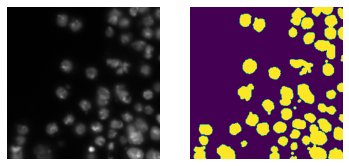

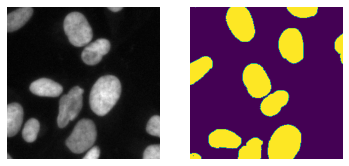

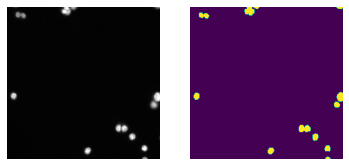

In [16]:
# TODO sample a few images from the dataset and verify that they are correct
for i in range(5):
  image, mask = train_dataset.__getitem__(i)[0][0], train_dataset.__getitem__(i)[1][0]
  fig, ax = plt.subplots(1, 2)
  ax[0].axis("off")
  ax[0].imshow(image, cmap="gray")
  ax[1].axis("off")
  ax[1].imshow(mask)
  plt.show()

The images you sample should look similar to this (using the standard colormap for the binarized mask):

![image.png](attachment:image.png)

### Implement the U-Net

Next, we will implement a U-Net architecture inspired [Ronneberger et al.](https://arxiv.org/abs/1505.04597), see the image below.

IMPORTANT: unlike in the publication / image we will use SAME convolutions, so that the input shape is the same as the output shape. This will introduce some boundary artifacts, but it will make implementing the rest of this exercise much simpler.
It also means that you don't need to crop the features passed on in the skip connections and can directly concatenate them.

![unet2d-architecture.png](attachment:unet2d-architecture.png)

HINTS: 
- the `up-conv` used here is called [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#convtranspose2d) in PyTorch.
- you can concatenate the features coming from the skip connectins and the encoder with `torch.cat`
- you will need `nn.ModuleList` to store the individual blocks of the encoder / decoder

Before you implement the U-Net, please answer the following QUESTIONS:
- What kind of architecture is the U-Net and what is the rationale behind this architecture?
    - The architecture consists of an encoding and decoding part. Inside the encoding part we use normal
      convolutions to extract features. In the decoding part we use transpose convolutions combined with
      concatenated spacial data to apply feature data to spacial data. The shape of the UNet is like a big U.
- What other types of architectures for semantic segmentation exist to achieve similar effects?
    - DeepLab v1 - v3
- Why are the skip connections used in the U-Net?
    - The bottom of the UNet cannot contain much spacial data, since there are not enough parameters. So in
      order to map the features to the image spacing, we need these skip connections.

TODO your answers here

In [17]:
# helper classes for unet
class Double_conv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels

    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding = 'same'),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3,padding = 'same'),
        #nn.ReLU(),
    )

  def forward(self, x):
    return self.double_conv(x)



class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            Double_conv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)



class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride  = 2)
    self.conv = Double_conv(in_channels, out_channels)

  '''def crop(self, enc_ftrs, x):
    print(x.shape)
    _, _, H, W = x.shape
    enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
    print(enc_ftrs.shape)
    return enc_ftrs'''

  def forward(self, x1, x2):
    x1 = self.up(x1)
    #x2_crop = self.crop(x2, x1)
    #x = torch.cat([x2_crop, x1], dim=1)
    x = torch.cat([x2, x1], dim=1)
    x = self.conv(x)
    return x


In [18]:
# TODO implement the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, last_layer_fn = None):
      super().__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels

      self.first = Double_conv(in_channels, 64)
      self.down1 = Down(64, 128)
      self.down2 = Down(128, 256)
      self.down3 = Down(256, 512)
      self.down4 = Down(512, 1024)
      self.up1 = Up(1024, 512)
      self.up2 = Up(512, 256)
      self.up3 = Up(256, 128)
      self.up4 = Up(128, 64)
      self.out = nn.Conv2d(64, out_channels, kernel_size=1)
      if last_layer_fn:
          self.last_layer_fn = last_layer_fn

    def forward(self, x):
      if display_size:
          print("input image size", x.shape)
      x1 = self.first(x)
    
      if display_size:
          print("after first layer", x1.shape)
      x2 = self.down1(x1)
        
      if display_size:
          print("after 2nd layer", x2.shape)
      x3 = self.down2(x2)
        
      if display_size:
          print("after 3rd layer", x3.shape)
      x4 = self.down3(x3)
        
      if display_size:
          print("after 4th layer", x4.shape)
      x5 = self.down4(x4)
        
      if display_size:
          print("after last downsample layer", x5.shape)
      x = self.up1(x5, x4)
        
      if display_size:
          print("after 1st uplayer", x.shape)
      x = self.up2(x, x3)
        
      if display_size:
          print("after 2 uplayer", x.shape)
      x = self.up3(x, x2)
        
      if display_size:
          print("after 3 uplayer", x.shape)
      x = self.up4(x, x1)
        
      if display_size:
          print("after 4 uplayer", x.shape)
      x = self.out(x)
        
      if display_size:
          print("output image", x.shape)
      
      if hasattr(self, "last_layer_fn"):
          x = self.last_layer_fn(x)
      return x

In [19]:
# TODO instantiate a unet and check that your architecture is correct by applying it to
# an input from the train loader
model = UNet(1,1).to(device)

In [20]:
# TODO display the prediction. Can you interpret the resulting image?
display_size = False
pred = model(torch.tensor(train_dataset.__getitem__(2)).to(device))

<ipython-input-20-b429e4cd2617>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  pred = model(torch.tensor(train_dataset.__getitem__(2)).to(device))


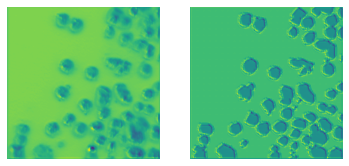

In [21]:
image, mask = pred[0][0].detach().cpu().numpy(), pred[1][0].detach().cpu().numpy()
fig, ax = plt.subplots(1, 2)
ax[0].axis("off")
ax[0].imshow(image)
ax[1].axis("off")
ax[1].imshow(mask)
plt.show()

## Training

Now we can define the training functions, similar to the last exercise, and then plot the results of loss and metrics

## Discussion:
Another way to monitor the loss, metrics and images during training and validation is [tensorboard](https://www.tensorflow.org/tensorboard). Note that usually the data for tensorboard is stored separately from the notebook files/scripts, so if you copy the scripts somewhere else you will not see the curves in tensorboard anymore.

In [22]:
# in this cell all the training and validation functions are implemented for you already;
# these implementations are fairly similar to the exercise where we trained a CNN on CIFAR

# normalize a tensor to range [0, 1] (per channel).
# this is needed to properly display the tensor as an image in tensorboard
def normalize(tensor):
  eps = 1e-6
  normed = tensor.numpy()
  minval = normed.min(axis=(0, 2, 3), keepdims=True)
  normed = normed - minval
  maxval = normed.max(axis=(0, 2, 3), keepdims=True)
  normed = normed / (maxval + eps)
  return torch.from_numpy(normed)

# train the model for one epoch
def train_epoch(model, loader, loss, metric, optimizer, as_dtype = None):
    model.train()
    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        if as_dtype:
            x, y = x.type(as_dtype), y.type(as_dtype)
        else:
            x, y = x.float(), y.float()
        pred = model(x)
        loss_value = loss(pred, y)
        
        loss_value.backward()
        optimizer.step()
        if metric is not None:
            metric_value = metric(pred, y)
            
    print(loss_value)


# validate the model
def validate(model, loader, loss, metric, as_dtype = None):
    model.eval()
    n_val = len(loader)
    metric_value, loss_value = 0.0, 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if as_dtype:
                x, y = x.type(as_dtype), y.type(as_dtype)
            else:
                x, y = x.float(), y.float()
            pred = model(x)
            loss_value += loss(pred, y).item()
            if metric is not None:
                metric_value += metric(pred, y).item()
        
    metric_value /= n_val
    loss_value /= n_val
    
    if extract_metrics:
        return metric_value, loss_value

# run the whole training
def run_training(
    model, train_loader, val_loader, loss, metric, optimizer, n_epochs, as_dtype = None):
    epoch_len = len(train_loader)
    step = 0
    for epoch in tqdm.trange(n_epochs):
        train_epoch(model, train_loader, loss, metric, optimizer, as_dtype = None)
        step = epoch_len * (epoch + 1)
        extract_metrics = False
        validate(model, val_loader, loss, metric)

We will use (per-pixel) binary cross entropy as a loss function. Pytorch offers to different implementations of this loss: [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) and [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

HINTS:
- The targets for BCE should be 'float32' values

QUESTIONS:
- What is the difference between the two different implementations?
  - BCEWithLogitsLoss = Sigmoid + BCELoss for numeric stability.
- Which one do we need to use here, and why?
  - BCEWithLogitsLoss since our model does not have a last activation function (sigmoid)

TODO your answers here

In [23]:
# TODO create the loss function
loss = torch.nn.BCEWithLogitsLoss()

Next, we want to define a suitable metric for measuring the quality of the (binary) network prediction. We will use the [dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) for this, which compares the intersection of prediction and target to their union.

In [24]:
# TODO implement the dice score as a function.
# HINTS: 
# - for later parts of this exercises, you should implement it in such a way that
# the function can compute the dice score for input and target with multiple channels,
# and so that it is computed independently per channel and the channel average is returned
# - since we don't have an activation in the U-Net you need to bring the predictions in range [0, 1] using torch.sigmoid
# - the dice score can be formulated for continuous predictions in [0, 1]; DO NOT threshold the predictions
def dice_score(input_, target):
    # assume (B, C, H, W)
    x = torch.nn.Sigmoid()(input_)
    y = target
    e = 0.0001
    return (2 * (x * y).sum(axis = [-1, -2]) + e) / ((x + y).sum(axis = [-1, -2]) + e) 

In [25]:
# TODO check your dice implementation for an example model prediction and the corresponding target
image, mask = map(lambda item: torch.Tensor(item).to(device), train_dataset.__getitem__(2))
d = dice_score(image, mask)
d.size()

print(image.size())
print(mask.size())
print(d.size())
print(d)

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1])
tensor([0.5262], device='cuda:0')


In [26]:
# train the model for 10 epochs, 
# after the training, check the plots to see how the model loss and metrics evolve,
# and to see predictions of the training data in real time
n_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
run_training(model, train_loader, val_loader, loss, dice_score, optimizer, n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.3616, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 10%|█         | 1/10 [00:28<04:19, 28.81s/it]

tensor(0.3110, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 20%|██        | 2/10 [00:56<03:47, 28.41s/it]

tensor(0.2450, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 30%|███       | 3/10 [01:24<03:17, 28.16s/it]

tensor(0.1392, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 40%|████      | 4/10 [01:52<02:48, 28.13s/it]

tensor(0.2653, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 50%|█████     | 5/10 [02:21<02:20, 28.14s/it]

tensor(0.2901, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 60%|██████    | 6/10 [02:49<01:52, 28.08s/it]

tensor(0.0765, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 70%|███████   | 7/10 [03:17<01:24, 28.06s/it]

tensor(0.0296, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 80%|████████  | 8/10 [03:44<00:56, 28.03s/it]

tensor(0.0805, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 90%|█████████ | 9/10 [04:12<00:28, 28.00s/it]

tensor(0.0218, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 10/10 [04:41<00:00, 28.11s/it]


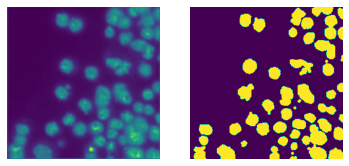

In [28]:
pred = model(torch.tensor(train_dataset.__getitem__(2)).to(device))
image, mask = pred[0][0].detach().cpu().numpy(), pred[1][0].detach().cpu().numpy()
_, mask = map(lambda x: x.squeeze(0), train_dataset.__getitem__(2))
fig, ax = plt.subplots(1, 2)
ax[0].axis("off")
ax[0].imshow(image)
ax[1].axis("off")
ax[1].imshow(mask)
plt.show()

## Evaluate on test data

Now, we will evaluate the **instance segmentation**  derived from the model predictions on the test data. To this end, we will use [connected components](https://en.wikipedia.org/wiki/Component_(graph_theory)#Algorithms) to convert the (binarized) network predictions into an instance segmentation. We will use the implementation from [skimage](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label).

QUESTION:
- Describe briefly what the connected components algorithm does when applied to a (binary) image. (You don't need to comment on the 'how' (implementation)).
  - As the name suggest it labels all connected components. Pixels that are connected by some metric (for example       nearby pixel) are given the same label. Applied to binary data we get all pixels that are connected via 
    foreground pixels (those with 1s). This is not the same as segmentation since multiple segments can be inside
    the same components.

TODO: your answer here

In [29]:
# TODO load and normalize the test images
test_image_paths = glob(os.path.join(data_folder, "test", "images", "*.tif"))
test_image_paths.sort()
test_mask_paths = glob(os.path.join(data_folder, "test", "masks", "*.tif"))
test_mask_paths.sort()
assert len(image_paths) == len(mask_paths)
test_images = [imageio.imread(i) for i in test_image_paths]
test_masks = [imageio.imread(i) for i in test_mask_paths]
test_ims_flat = np.concatenate([im.ravel() for im in test_images])
test_mean, test_std = np.mean(ims_flat), np.std(ims_flat)
test_images = [(im.astype("float32") - test_mean) / test_std for im in test_images]

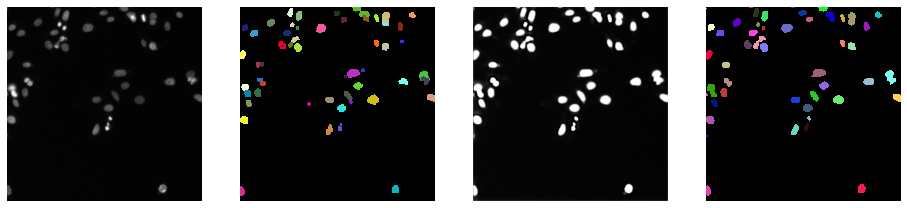

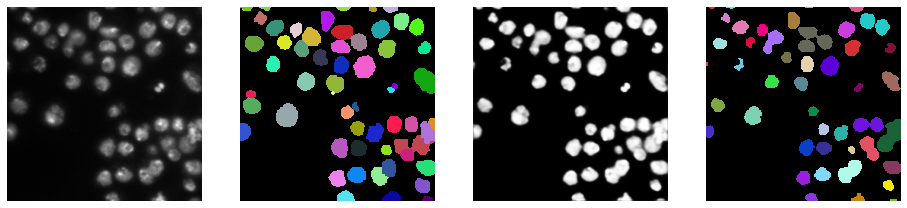

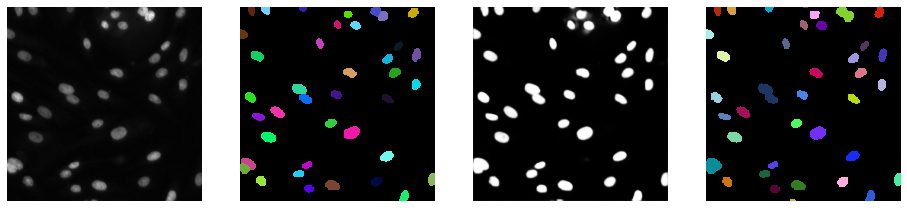

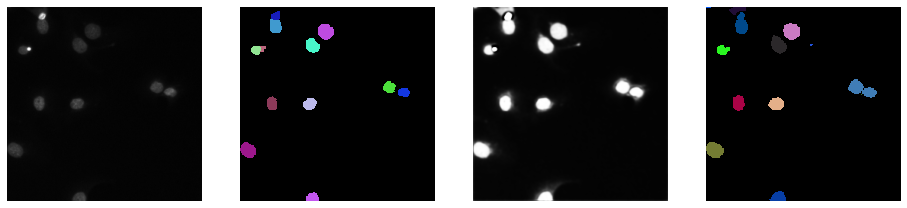

In [30]:
# check out instance segmentation for a few test images
counter = 0
with torch.no_grad():
    for im, mask in zip(test_images, test_masks):
        if counter > 3:
            break
        # predict with the model and apply sigmoid to map the prediction to the range [0, 1]
        pred = model(torch.from_numpy(im[None, None]).to(device))
        pred = torch.sigmoid(pred).cpu().numpy().squeeze()
        # get tbe nucleus instance segmentation by applying connected components to the binarized prediction
        nuclei = label(pred > 0.5)
        fig, ax = plt.subplots(1, 4, figsize=(16, 16))
        ax[0].axis("off")
        ax[0].imshow(im, cmap="gray")
        ax[1].axis("off")
        ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
        ax[2].axis("off")
        ax[2].imshow(pred, cmap="gray")
        ax[3].axis("off")
        ax[3].imshow(nuclei, cmap=get_random_colors(nuclei), interpolation="nearest")
        plt.show()
        counter += 1

In [31]:
# we also need a measure for the instance segmentation quality.
# here, we use intersection over union (for each ground-truth object).
# it is implemented for you already below

def precision(tp, fp, fn):
    return tp / (tp + fp) if tp > 0 else 0


def compute_ious(seg, mask):
    overlap = contingency_table(seg, mask).toarray()
    n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
    n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
    eps = 1e-7
    ious = overlap / np.maximum(n_pixels_pred + n_pixels_true - overlap, eps)
    # ignore matches with zero (= background)
    ious = ious[1:, 1:]
    n_pred, n_true = ious.shape
    n_matched = min(n_pred, n_true)
    return n_true, n_matched, n_pred, ious

    
def compute_tps(ious, n_matched, threshold):
    not_trivial = n_matched > 0 and np.any(ious >= threshold)
    if not_trivial:
        # compute optimal matching with iou scores as tie-breaker
        costs = -(ious >= threshold).astype(float) - ious / (2*n_matched)
        pred_ind, true_ind = linear_sum_assignment(costs)
        assert n_matched == len(true_ind) == len(pred_ind)
        match_ok = ious[pred_ind, true_ind] >= threshold
        tp = np.count_nonzero(match_ok)
    else:
        tp = 0
    return tp


def intersection_over_union(seg, mask, threshold=0.5):
    if seg.sum() == 0:
        return 0.0
    n_true, n_matched, n_pred, ious = compute_ious(seg, mask)
    tp = compute_tps(ious, n_matched, threshold)
    fp = n_pred - tp
    fn = n_true - tp
    ap = precision(tp, fp, fn)
    return ap

In [32]:
# Compute the average IOU of all the test images
ious = []
model.eval()
with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        # the model can only predict images with a spatial size that is divisible by 16
        # if it isn't we just cat a few pixels to make it fit
        if any(sh % 16 != 0 for sh in im.shape):
            crop = tuple(
                slice(0, -(sh%16)) for sh in im.shape
            )
            im = im[crop]
            mask = mask[crop]
        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.sigmoid(pred).cpu().numpy().squeeze()
        labels = label(pred > 0.5)
        
        iou = intersection_over_union(labels, mask)
        ious.append(iou)
print()
print("Mean IoU:", np.mean(ious))

100%|██████████| 50/50 [00:02<00:00, 20.08it/s]


Mean IoU: 0.6472665085036949


QUESTION:
- Given the samples of the instance segmentations from above, what are the biggest sources of error you can identify in the model predictions / instance segmentation approach?
  - The biggest problem is that the inside of each nuclei is often labeled as
    background. Sometimes multiple nuclei are merged too.
- How could they be overcome?
  - One could afterwards fill out the middle by post-processing. Another
    approach is to decrease the threshold.

TODO your answer here

## Train with boundary channel

To avoid merges of touching nuclei, we will now add a boundary channel to the learning objective, and then use it for object separation in the instance segmentation funtion. To this end, we will train a U-Net that outputs 3 channels (background, foreground, object boundary) and use the cross entropy loss.

In [33]:
# TODO implement a transform that outputs an image with 3 values:
# 0 for backgorund, 1 for foreground (= nucleus) and 2 for boundary (boundary pixel between nucleus and background or between 2 nuclei)
# HINT: you can use skimage.segmentation.find_boundaries (already imported) to determine the boundary pixels
# def label_transform(mask):
#    boundaries = find_boundaries(mask)
#    boundaries = boundaries.astype(int) * 2
#    nuclei = mask.astype(int)
#    output = boundaries + nuclei
#    output = np.expand_dims(output, axis=0)
#    return output
def label_transform(mask):
    boundaries = find_boundaries(mask)
    nuclei = mask.astype(int)
    background = (~mask) & (~boundaries)
    output = np.stack((background, nuclei, boundaries), axis=0)
    return output

In [34]:
# instantiate the training and validation datasets with the new label transform
train_dataset = NucleiDataset(
    train_images, train_masks, mask_transform=label_transform
)
val_dataset = NucleiDataset(
    val_images, val_masks, mask_transform=label_transform
)

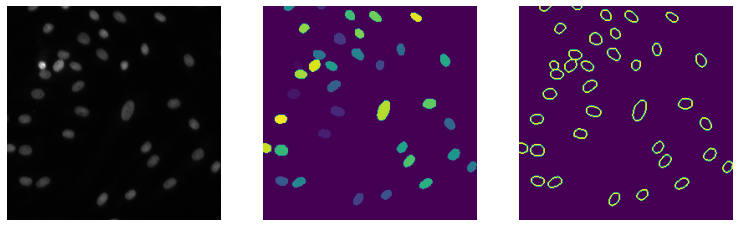

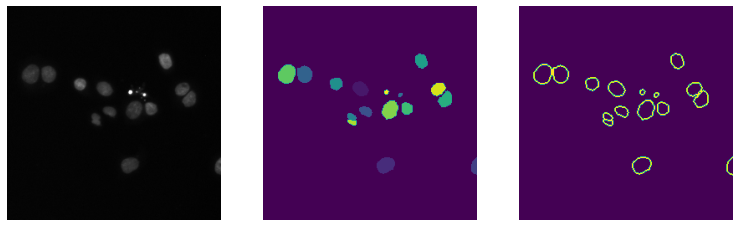

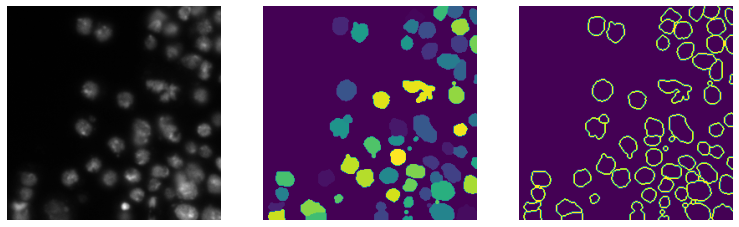

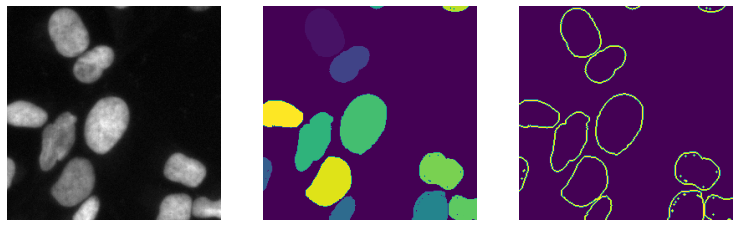

In [35]:
# visualize the new label transform and make sure it's correct
counter = 0
for im, target in train_dataset:
    if counter > 3:
        break
    fig, ax = plt.subplots(1, 3, figsize=(13, 13))
    ax[0].axis("off")
    ax[0].imshow(im[0], cmap="gray")
    ax[1].axis("off")
    ax[1].imshow(target[1,:,:])
    ax[2].axis("off")
    ax[2].imshow(target[2,:,:])
    # ax[1].imshow(target)
    plt.show()
    counter += 1

In [52]:
# TODO instantiate the new unet and loss function
model = UNet(1, 3).to(device)
loss = torch.nn.CrossEntropyLoss()

In [53]:
# train the new U-Net for 10 epochs
# (we don't use a metric here, since the target (with class labels 0, 1, 2) and prediction (one-hot encoding) have different representations
n_epochs = 10
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = None
run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(5.4422, device='cuda:0', grad_fn=<DivBackward1>)


 10%|█         | 1/10 [00:28<04:14, 28.29s/it]

tensor(1.0490, device='cuda:0', grad_fn=<DivBackward1>)


 20%|██        | 2/10 [00:56<03:46, 28.31s/it]

tensor(0.1859, device='cuda:0', grad_fn=<DivBackward1>)


 30%|███       | 3/10 [01:24<03:16, 28.12s/it]

tensor(1.2348, device='cuda:0', grad_fn=<DivBackward1>)


 40%|████      | 4/10 [01:52<02:48, 28.07s/it]

tensor(2.0897, device='cuda:0', grad_fn=<DivBackward1>)


 50%|█████     | 5/10 [02:20<02:20, 28.09s/it]

tensor(0.8842, device='cuda:0', grad_fn=<DivBackward1>)


 60%|██████    | 6/10 [02:48<01:52, 28.08s/it]

tensor(0.7619, device='cuda:0', grad_fn=<DivBackward1>)


 70%|███████   | 7/10 [03:16<01:24, 28.06s/it]

tensor(0.1393, device='cuda:0', grad_fn=<DivBackward1>)


 80%|████████  | 8/10 [03:44<00:56, 28.05s/it]

tensor(0.3166, device='cuda:0', grad_fn=<DivBackward1>)


 90%|█████████ | 9/10 [04:12<00:28, 28.06s/it]

tensor(0.8410, device='cuda:0', grad_fn=<DivBackward1>)


100%|██████████| 10/10 [04:40<00:00, 28.09s/it]


In [38]:
# TODO write instance segmentation function where you first subtract the  boundary from the foreground prediction,
# and then apply connected components to the result in order to get the instances
# the parameter 'threshold' should determine at which threshold the result is binarized before applying connected components 
# HINT: you can use skimage.segmentation.watershed (already implemented) afterwards to grow the segmentation back so that it
# covers the full prediction while keeping the instance labels
def instance_segmentation(foreground_prediction, boundary_prediction, threshold=0.5):
    foreground_without_boundary = foreground_prediction - boundary_prediction
    binary_mask = foreground_without_boundary > threshold
    connected_components = label(binary_mask)
    instance_labels = skimage.segmentation.watershed(foreground_prediction,
        markers=connected_components, mask=binary_mask, watershed_line=False)
    return instance_labels

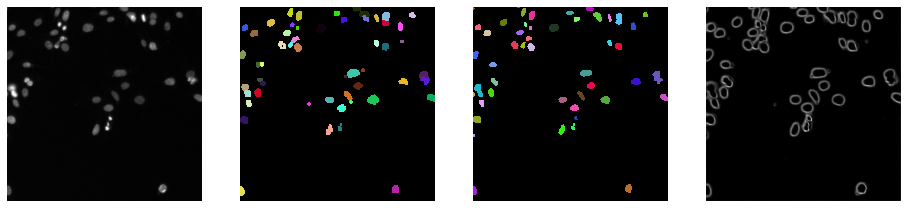

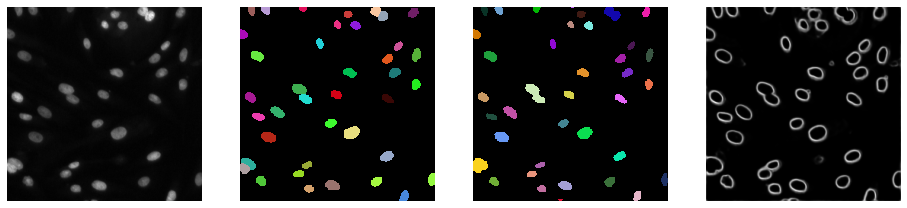

In [60]:
# TODO check the prediction results and instance segmentation for a few images
# make sure your instance segmentation implementation is correct
# HINT: you need to apply a softmax to the network predictions
counter = 0
with torch.no_grad():
    for im, mask in zip(test_images, test_masks):
        if counter > 3:
            break
        # predict with the model and apply sigmoid to map the prediction to the range [0, 1]
        pred = model(torch.from_numpy(im[None, None]).to(device))
        pred = torch.softmax(pred, dim = 1).cpu().numpy().squeeze()
        nuclei = instance_segmentation(pred[1], pred[2], threshold = 0.9)

        fig, ax = plt.subplots(1, 4, figsize=(16, 16))
        ax[0].axis("off")
        ax[0].imshow(im, cmap="gray")
        ax[1].axis("off")
        ax[1].imshow(mask, cmap=get_random_colors(mask), interpolation="nearest")
        ax[2].axis("off")
        ax[2].imshow(nuclei, cmap=get_random_colors(nuclei), interpolation="nearest")
        ax[3].axis("off")
        ax[3].imshow(pred[2], cmap='gray')
        plt.show()
        counter += 1


In [61]:
# TODO use the validation set to find a good value for the 'threshold' parameter in the instance_segmentation function
best_threshold = 0.9

In [62]:
# Compute the average IOU of all the test images
ious = []
model.eval()
with torch.no_grad():
    for im, mask in tqdm.tqdm(zip(test_images, test_masks), total=len(test_images)):
        if any(sh % 16 != 0 for sh in im.shape):
            crop = tuple(
                slice(0, -(sh%16)) for sh in im.shape
            )
            im = im[crop]
            mask = mask[crop]
        
        input_ = torch.from_numpy(im[None, None]).to(device)
        pred = model(input_)
        pred = torch.softmax(pred, dim=1).cpu().numpy().squeeze()
        assert pred.shape[0] == 3
        nuclei = instance_segmentation(pred[1], pred[2])

        iou = intersection_over_union(nuclei, mask, best_threshold)
        ious.append(iou)
print()
print(np.mean(ious))

100%|██████████| 50/50 [00:03<00:00, 14.52it/s]


0.09110865441445101


QUESTIONS:
- Did training with the boundaries and using them in the instance segmentation improve the results?
  - It did solve the problem that the middle was not marked correctly. However now different nuclei are merged.
- Can you think of ways to improve the loss function for this learning task?
  - We could combine multiple loss functions together "to get the best of both worlds", such as Dice. The Dice loss was more accurate, but the cross entropy version was more smooth. Maybe a combination gives us a good tradeoff.

TODO your answers here

## [Optional] Use the dice coefficient as loss function

Since our target is quite unbalanced (in particular the boundary channel), it can be benificial to use a balanced loss function. Here, we will use the Dice coefficient, which we have before used as metric, as loss function, since it is robust against unbalanced targets.
Note that we do not need to predict a channel with background prediction when using the dice coefficient as a loss (unlike with Cross Entropy).

In [42]:
# TODO implement a loss function based on the dice coefficient
# HINT: the dice coefficient is in range [0, 1] and higher values correspond to a better result
# Loss functions are minimized, so lower values should correspond to a better result

In [43]:
# TODO implement and compare with different loss function variations

## [Optional] Try variations of the UNet architecture

- add BatchNorm
- replace TransposedConvs with bilinear upsampling and 1x1 convs
- use residual blocks instead of the normal convolutional blocks

In [44]:
# TODO implement and compare u-net architecture variations

## [Optional] Train with data augmentation

- rotations & flips
- noise augmentations (add gaussian noise and/or poisson noise)
- crop and resize

Hint: use the `image_transform` (noise augmentations) and `transform` (geometrical augmentations) argument of the `NucleiDataset`

In [45]:
# TODO implement data augmentations and compare with training without augmentations

# Denoising with Noise2Noise

Here, we implement [Noise2Noise](https://arxiv.org/abs/1803.04189), which is a method to learn image denoising **without** ground-truth, by using a different noisy image as target. Note that we are re-using the same architecture as before, which is a bit different from the one used in the paper.

## Data Preparation

We use the [VSDR dataset](https://cv.snu.ac.kr/research/VDSR), which contains 'clean' (i.e. without noise) natural images.

In [46]:
# Download the VSDR data
!conda install -y gdown
!gdown --id 1hNB5_MkxutrKLa1g35tSLCiq1J5xxH9F --folder

os.makedirs("/kaggle/working/dlforcv-ex5", exist_ok=True)

!unzip "/kaggle/working/VDSR/train_data.zip" -d "dlforcv-ex5/vsdr_train"
!unzip "/kaggle/working/VDSR/test_data.zip" -d "dlforcv-ex5/vsdr_test"

/bin/bash: conda: command not found
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder list
Processing file 1O5TcV-srsncaLrQck2G8yo5cNDvQpg9X test_data.zip
Processing file 1jZMi_Q4uambklnyjMUcZFotb3_K9EKcX train_data.zip
Retrieving folder list completed
Building directory structure
Building directory structure completed
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1O5TcV-srsncaLrQck2G8yo5cNDvQpg9X 

Download ended unsuccessfully
unzip:  cannot find or open /kaggle/working/VDSR/train_data.zip, /kaggle/working/VDSR/train_data.zip.zip or /kaggle/working/VDSR/train_data.zip.ZIP.
unzip

In [47]:
# setting paths for the training and testing data
vsdr_train = "/kaggle/working/dlforcv-ex5/vsdr_train/"
vsdr_test = "/kaggle/working/dlforcv-ex5/vsdr_test/"

In [48]:
# check the unique image sizes in the training data
image_exts = (".jpeg", ".jpg", ".png", ".bmp")
all_image_paths = [
    p for p in Path(vsdr_test).glob("**/*") if p.suffix.lower() in image_exts
]
shapes = []
for p in all_image_paths:
    shapes.append(imageio.imread(p).shape)
unique_shapes = list(set(shapes))
print(unique_shapes)

[]


In [49]:
# vsdr dataset that can deal with all the different data sizes in the training and test data
class VsdrDataset(Dataset):
    def __init__(self, root_dir, noise_transform):
        image_exts = (".jpeg", ".jpg", ".png", ".bmp")
        self.image_paths = [
            p for p in Path(root_dir).glob("**/*") if p.suffix.lower() in image_exts
        ]
        self.noise_transform = noise_transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        im = np.array(imageio.imread(self.image_paths[index]))
        if im.ndim == 2:
            im = np.concatenate([im[..., None]] * 3, axis=2)
        if im.shape[-1] == 1:
            im = np.concatenate([im] * 3, axis=2)
        target_shape = (256, 256)
        # first, pad the images if they are smaller than the target crop shape
        if any(sh < tsh for sh, tsh in zip(im.shape[:-1], target_shape)):
            padding = tuple((0, tsh - sh if sh < tsh else 0) for sh, tsh in zip(im.shape[:-1], target_shape))
            padding = padding + ((0, 0),)
            im = np.pad(im, padding, mode="reflect")
        # then crop tham if they are too large
        if any(sh > tsh for sh, tsh in zip(im.shape[:-1], target_shape)):
            crop_start = [np.random.randint(0, sh - tsh) if sh != tsh else 0 for sh, tsh in zip(im.shape[:-1], target_shape)]
            crop = tuple(slice(cs, cs + tsh) for cs, tsh in zip(crop_start, target_shape))
            im = im[crop]
        assert im.shape == (256, 256, 3), f"{im.shape}"
        
        # normalize the image to range [0, 1] (per channel)
        im = im.astype("float32")
        im -= im.min(axis=(0, 1), keepdims=True)
        im /= im.max(axis=(0, 1), keepdims=True)
        # bring image in range [-1, 1]
        im = 2 * im - 1
        
        # transform to channel first order
        im = im.transpose((2, 0, 1))
        # apply the noise transformation
        return self.noise_transform(im)

In [50]:
# go from range [-1, 1] to [0, 255] and uint 8
# and go to channel last order
def to_display(im):
    im = (((im + 1) / 2) * 255).astype("uint8")
    return im.transpose((1, 2, 0))

In [51]:
# sample a few images
check_dataset = VsdrDataset(vsdr_train, lambda x: x)
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
for ii in range(16):
    im = check_dataset[ii]
    #im = additive_gaussian_noise(im, 0.1)
    ax[ii % 4, ii // 4].axis("off")
    ax[ii % 4, ii // 4].imshow(to_display(im))
plt.show()

IndexError: ignored

## Train a network with clean targets

As the first baseline, we will train a network with clean target data (i.e. without noise added to it). 

In [ ]:
# instatiate the model and loss function (Mean Squared Error)
model_noise2NoNoise = UNet(in_channels=3, out_channels=3)
model_noise2NoNoise.to(device)
loss = nn.MSELoss()
loss.to(device)

In [ ]:
# we will use the PSNR (peak signal to noise ratio) as metric to evaluate the predictions.
# you can read up on it and the implementation we are using here:
# https://www.ni.com/en-us/innovations/white-papers/11/peak-signal-to-noise-ratio-as-an-image-quality-metric.html
# (the higher the PSNR, the better)

def to_uint8(im):
    return torch.clamp((im + 0.5) * 255.0 + 0.5, 0, 255).type(torch.uint8)


class PSNR(nn.Module):
    def __call__(self, x, y):
        x, y = to_uint8(x), to_uint8(y)
        x, y = x.detach().cpu().numpy(), y.detach().cpu().numpy()
        return peak_signal_noise_ratio(x, y)

QUESTION:
- What does the PSNR metric measuere?
- Why is it used instead of 'just' computing the pixel wise error (MSE)?

TODO your answer here

Peak signal to noise ratio: $10 log_10 \frac{R^2}{MSE}$, where $R$ is the maximum fluctuation in the input image. As we can see, PSNR has a negative correlation to MSE. PSNR is more intuitive than MSE, where its value resembles the quality of an image as we humans understand it.

In [ ]:
# TODO implement a function that adds additive gaussian noise to the input
# the var argument should correspond to the variance of the gaussian
def additive_gaussian_noise(x, var):

    mean = 0

    std = var**0.5
    d, m, n = x.shape
    gaussian_noise = np.random.normal(mean, std, (d, m, n))
    noisy = x + gaussian_noise
    
    return noisy

In [ ]:
check_dataset_list =list(check_dataset)

In [ ]:
np.random.seed(12)
idx = np.arange(0,len(check_dataset_list))
idx = np.random.permutation(idx)
train_size = int(len(check_dataset_list)*0.9)

check_dataset_with_target = [(additive_gaussian_noise(check_dataset_list[i], 0.1),check_dataset_list[i]) for i in range(len(check_dataset_list))]

In [ ]:
# TODO instantiate a vsdr dataset corresponding to the vsdr_train folder 
# with a noise transformation that returns a corrupted image (as network input)
# and a clean image (as target)
# use a variance of 0.1
# split the dataset into a train (90% of the data) and validationd dataset (10%)
# HINT: you can use torch.utils.data.random_split to split a torch dataset
vsdr_train_ds = check_dataset_with_target[: train_size]
vsdr_val_ds = check_dataset_with_target[train_size: ]

In [ ]:
# sample a few images from the train dataset
fig, ax = plt.subplots(3, 2, figsize=(16, 16))
for ii in range(3):
    noisy, clean = vsdr_train_ds[ii]
    # go back to uint8
    ax[ii, 0].axis("off")
    ax[ii, 0].imshow(to_display(noisy))
    ax[ii, 1].axis("off")
    ax[ii, 1].imshow(to_display(clean))
plt.show()

In [ ]:
# train the denoising network
display_size = False

from torch.utils.tensorboard import SummaryWriter
n_epochs = 10
logger = SummaryWriter("runs/noise2noise-1")
train_loader = DataLoader(vsdr_train_ds, batch_size=1, shuffle=True) 
val_loader = DataLoader(vsdr_val_ds, batch_size=1)
optimizer = torch.optim.Adam(model_noise2NoNoise.parameters(), lr=1e-4)
metric = PSNR()
#run_training(model, train_loader, val_loader, loss, metric, optimizer, n_epochs, logger)
run_training(model_noise2NoNoise, train_loader, val_loader, loss, metric, optimizer, n_epochs)

In [ ]:
# create the test dataset
vsdr_test_ds = VsdrDataset(
    vsdr_test,
    noise_transform=lambda x: (additive_gaussian_noise(x, var=0.1), x)
)

In [ ]:
display_size = False
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for ii in range(3):
    noisy, clean = vsdr_train_ds[ii]

    #print(torch.tensor(noisy.reshape(1,3,256,256)).shape)
    t_noisy = torch.tensor(clean.reshape(1,3,256,256))
    pred  = model_noise2NoNoise(t_noisy.float().to(device))
    np_prediction = pred.detach().cpu().squeeze().numpy()

    # go back to uint8
    ax[ii, 0].axis("off")
    ax[ii, 0].imshow(to_display(noisy))
    ax[ii, 1].axis("off")
    ax[ii, 1].imshow(to_display(clean))
    ax[ii, 2].axis("off")
    ax[ii, 2].imshow(to_display(np_prediction))
plt.show()

In [ ]:
# TODO display some results on the test data

fig, ax = plt.subplots(3, 3, figsize=(16, 16))
for ii in range(3):
    noisy, clean = vsdr_test_ds[ii]
    
    t_noisy = torch.tensor(clean.reshape(1,3,256,256))
    pred  = model_noise2NoNoise(t_noisy.float().to(device))
    np_prediction = pred.detach().cpu().squeeze().numpy()
    # go back to uint8
    ax[ii, 0].axis("off")
    ax[ii, 0].imshow(to_display(noisy))
    ax[ii, 1].axis("off")
    ax[ii, 1].imshow(to_display(clean))
    ax[ii, 2].axis("off")
    ax[ii, 2].imshow(to_display(np_prediction))
plt.show()

## Train a network with noisy targets (Gaussian noise)

Now, we train a network from noisy inputs AND noisy targets. And compare its results to the previous denoising network learned on clean targets.

QUESTION:
- Why can the model learn denoising even though we also have a noisy target?

In the process of encoding and decoding the data, we always lose some information that do not explain the data very well, which is the reason why the reconstructed image is sometimes blurry. This also sometimes includes the noise.

TODO your answer here

In [ ]:
# instantiate new model and loss
model_noise2noise = UNet(in_channels=3, out_channels=3)
model_noise2noise.to(device)
loss = nn.MSELoss()
loss.to(device)

In [ ]:
# TODO create dataset with corrupted input and target
# use same variance as before (0.1)
np.random.seed(12)
idx = np.arange(0,len(check_dataset_list))
idx = np.random.permutation(idx)
train_size = int(len(check_dataset_list)*0.9)

check_dataset_with_target_noise2noise = [(additive_gaussian_noise(check_dataset_list[i], 0.1),additive_gaussian_noise(check_dataset_list[i], 0.1)) for i in range(len(check_dataset_list))]
vsdr_train_ds_noise2noise = check_dataset_with_target_noise2noise[: train_size]
vsdr_val_ds_noise2noise = check_dataset_with_target_noise2noise[train_size: ]

In [ ]:
# train the model
n_epochs = 10
train_loader = DataLoader(vsdr_train_ds_noise2noise, batch_size=1, shuffle=True) 
val_loader = DataLoader(vsdr_val_ds_noise2noise, batch_size=1)
optimizer = torch.optim.Adam(model_noise2noise.parameters(), lr=1e-4)
metric = PSNR()
run_training(model_noise2noise, train_loader, val_loader, loss, metric, optimizer, n_epochs)

In [ ]:
# TODO show a few predictions for the test dataset

fig, ax = plt.subplots(3, 3, figsize=(16, 16))
for ii in range(3):
    noisy, clean = vsdr_test_ds[ii]

    #print(torch.tensor(noisy.reshape(1,3,256,256)).shape)
    t_noisy = torch.tensor(clean.reshape(1,3,256,256))
    pred  = model_noise2noise(t_noisy.float().to(device))
    np_prediction = pred.detach().cpu().squeeze().numpy()

    # go back to uint8
    ax[ii, 0].axis("off")
    ax[ii, 0].imshow(to_display(noisy))
    ax[ii, 1].axis("off")
    ax[ii, 1].imshow(to_display(np_prediction))
    ax[ii, 2].axis("off")
    ax[ii, 2].imshow(to_display(np_prediction))
plt.show()

In [ ]:
extract_metrics = True
loss = nn.MSELoss()
metric = PSNR()
vsdr_all_ds_noise2noise = check_dataset_with_target_noise2noise[:]
vsdr_all_ds_noise2NoNoise = check_dataset_with_target[:]
all_loader1 = DataLoader(vsdr_all_ds_noise2noise, batch_size=1, shuffle=True) 
all_loader2 = DataLoader(vsdr_all_ds_noise2NoNoise, batch_size=1, shuffle=True) 
psnr_noise2noise_all_dataset, loss_noise2noise_all_dataset = validate(model_noise2noise, all_loader1, loss, metric)

psnr_noise2NoNoise_all_dataset, loss_noise2NoNoise_all_dataset = validate(model_noise2NoNoise, all_loader2, loss, metric)

In [ ]:
print(psnr_noise2noise_all_dataset, psnr_noise2NoNoise_all_dataset)

# TODO compute the PSNR for the whole test dataset
vsdr_whole_ds_noise2noise = check_dataset_with_target_noise2noise[:]
all_loader = DataLoader(vsdr_whole_ds_noise2noise, batch_size=1, shuffle=True)
loss = nn.MSELoss()
metric = PSNR()
extract_metrics = True
validate(model_noise2noise, all_loader, loss, metric) 

QUESTIONS:
- Compare the result between the network trained with clean targets and with noisy targets.

****TODO your answer here

As we can see, the PSNR for the noise to no noise is higher, indicating a better performance.

## [Optional] Train a network with noisy targets (Poisson noise)

Use poisson noise instead of gaussian noise and compare to both the network trained with clean target and the network with the target corrupted by gaussian noise.

In [ ]:
# TODO run training with poisson noise and compare with previous results

## [Optional] Use U-Net with BatchNorm

Repeat the exercise with a U-Net with BatchNorm. Does this improve the results?

In [ ]:
# TODO use a U-Net architecture with BatchNorm and compare with previous results